In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from sklearn import model_selection

In [2]:
# Import Images dataset (covid, Laug_Opacity, Normal and Pnuemonia)

In [3]:
image_dir = ".\\covid19dataset"
image_dir

'.\\covid19dataset'

In [4]:
import pathlib 
image_dir = pathlib.Path(image_dir)
image_dir

WindowsPath('covid19dataset')

In [5]:
all_image_dir = list(image_dir.glob('**\*.png'))
all_image_dir[-5:]

[WindowsPath('covid19dataset/Viral_Pneumonia/images/Viral Pneumonia-995.png'),
 WindowsPath('covid19dataset/Viral_Pneumonia/images/Viral Pneumonia-996.png'),
 WindowsPath('covid19dataset/Viral_Pneumonia/images/Viral Pneumonia-997.png'),
 WindowsPath('covid19dataset/Viral_Pneumonia/images/Viral Pneumonia-998.png'),
 WindowsPath('covid19dataset/Viral_Pneumonia/images/Viral Pneumonia-999.png')]

In [6]:
# accessing each image specific X-ray folders and files

In [7]:
covid_dir = list(image_dir.glob('COVID/images/*'))
# lung_opacity_dir = list(image_dir.glob('Lung_Opacity/images/*'))
# normal_dir = list(image_dir.glob('Normal/images/*'))
pneumonia_dir = list(image_dir.glob('Viral_Pneumonia/images/*'))

In [8]:
# EXPLORING DATA SIZE ....
print('Covid data size:', len(covid_dir))
# print('Lung Opacity data size:', len(lung_opacity_dir))
# print('Normal data Size' , len(normal_dir))
print('Pneumonia data size', len(pneumonia_dir))

# print('Total Image Datase ------->>>>>>>' , len(all_image_dir))
print('Total Image Datase ------->>>>>>>' , len(covid_dir) + len(pneumonia_dir))

Covid data size: 3616
Pneumonia data size 1345
Total Image Datase ------->>>>>>> 4961


In [9]:
# VISUALIZAING IMAGE ........

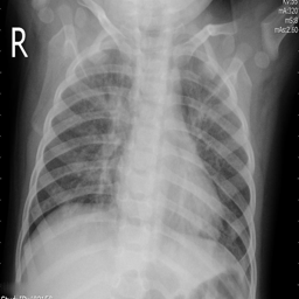

In [12]:
PIL.Image.open(str(pneumonia_dir[0]))

In [13]:
#  CREATING A DICTIONARY FOR IMAGE AND LABELS......

In [1]:
covid_image_dic ={
    'covid':covid_dir,
#     'normal':normal_dir,
#     'lung_opacity':lung_opacity_dir,   
    'pneumonia':pneumonia_dir
}

NameError: name 'covid_dir' is not defined

In [ ]:
covid_label_dict = {
    "covid":0,
#     'normal':1,
#     'lung_opacity':2,
    'pneumonia':1
}

In [16]:
image = cv2.imread(str(covid_image_dic['covid'][0]))
image.shape

(299, 299, 3)

In [17]:
# LOADING DATA USING THE DICTIONARY

In [18]:
X , y = [], []

# lopping through the image dictionary 
for title, paths in covid_image_dic.items():
    print(f'Title :{title} <<<<<------------->>>>> Data Size: {len(paths)}')
    for path in paths:
        image = cv2.imread(str(path))
        r_image = cv2.resize(image, (180,180))
        X.append(r_image)
        y.append(covid_label_dict[title])

print("Execution completed.....................................")

Title :covid <<<<<------------->>>>> Data Size: 3616
Title :pneumonia <<<<<------------->>>>> Data Size: 1345
Execution completed.....................................


In [19]:
# converting to numpy array for conviniency 
X = np.array(X)
y = np.array(y)

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=0 )

NameError: name 'model_selection' is not defined

In [24]:
print('x train shape' , X_train.shape)
print('y train shape' , y_train.shape)
print('x test shape', X_test.shape)
print('y test shape', y_test.shape)

x train shape (3720, 180, 180, 3)
y train shape (3720,)
x test shape (1241, 180, 180, 3)
y test shape (1241,)


In [25]:
# scalling the image sample to improve accuracy
# X_train_scaled = X_train/255
# X_test_scaled = X_text/255

In [26]:
# CREATING LBP IMAGE FEATURES...........

In [27]:
def getLBPimage(gray_image):
    '''
    == Input ==
    gray_image  : color image of shape (height, width)
    
    == Output ==  
    imgLBP : LBP converted image of the same shape as 
    '''
    
    ### Step 0: Step 0: Convert an image to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgLBP = np.zeros_like(gray_image)
    neighboor = 3 
    for ih in range(0,image.shape[0] - neighboor):
        for iw in range(0,image.shape[1] - neighboor):
            ### Step 1: 3 by 3 pixel
            img          = gray_image[ih:ih+neighboor,iw:iw+neighboor]
            center       = img[1,1]
            img01        = (img >= center)*1.0
            img01_vector = img01.T.flatten()
            # it is ok to order counterclock manner
            # img01_vector = img01.flatten()
            ### Step 2: **Binary operation**:
            img01_vector = np.delete(img01_vector,4)
            ### Step 3: Decimal: Convert the binary operated values to a digit.
            where_img01_vector = np.where(img01_vector)[0]
            if len(where_img01_vector) >= 1:
                num = np.sum(2**where_img01_vector)
            else:
                num = 0
            imgLBP[ih+1,iw+1] = num
    return(imgLBP)

In [ ]:
lbp_features = [] 
for image in X:
    lbp_img = getLBPimage(image)
    lbp_features.append(lbp_img)

print("feature extraction completed...")

In [ ]:
lbp_image = lbp_features[0]
plt.imshow(lbp_image)

In [22]:
#  CREATING A CONVOLUTIONAL NEURAL NETWORK (CNN)

In [ ]:
classes = 4

cnn_model = tf.keras.Sequential([
    #   cnn and max pooling layer 1
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(180,180,3)),
    keras.layers.MaxPooling2D(),
    
    #   cnn and max pooling layer 2  
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    #   cnn and max pooling layer 3  
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    # neuron network dense
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(classes, activation='sigmoid')
])



cnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

In [ ]:
cnn_model.fit(X_train, y_train, epochs=5)

In [ ]:
cnn_model.evaluate(X_test, y_test)

In [ ]:
#  APPLYING HISTOGRAM OF ORIENTED GRADIENT (HOG)..... TO THE ORIGINAL DATASET

In [80]:
from skimage.feature import hog

In [81]:
len(X)

4961

In [82]:
# its required to reshape image to 128,64
resized_images  = [] 
for image in X:
    img = cv2.resize(image, (64,128))
    resized_images.append(img)
    
print('Resize Execution Completed.....')

Resize Execution Completed.....


In [83]:
len(resized_images)

4961

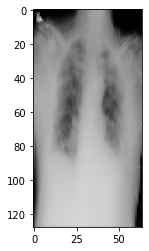

In [84]:
plt.imshow(resized_images[0])

In [85]:
img = resized_images[0]
img.shape

(128, 64, 3)

In [86]:
#  GENERATING HOG FEATURE

In [87]:
fd , hog_feature = hog(img, orientations=9 , pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True)

C:\Users\binary\AppData\Local\Temp\ipykernel_1724\2383769827.py:1: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd , hog_feature = hog(img, orientations=9 , pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True)


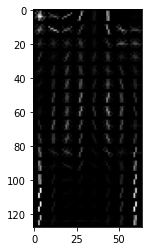

In [88]:
plt.imshow(hog_feature, cmap='gray')

In [89]:
hog_feature.shape

(128, 64)

In [90]:
#  after image is resized now let create HOG feature from each resize images
hog_features = []
for r_image in resized_images:
    fd , hog_feature_image = hog(r_image, orientations=9 , pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True)
    hog_features.append(hog_feature_image)

C:\Users\binary\AppData\Local\Temp\ipykernel_1724\1476485804.py:4: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd , hog_feature_image = hog(r_image, orientations=9 , pixels_per_cell=(8,8), cells_per_block=(2,2), visualize=True, multichannel=True)


In [91]:
len(hog_features)

4961

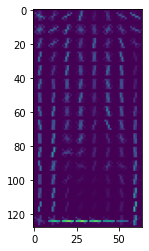

In [92]:
plt.imshow(hog_features[100])

In [93]:
# saving the images
# labels =    "covid",'normal','lung_opacity','pneumonia'
# for i in arrang()
# plt.imsave("covid19dataset/HOG/")

In [94]:
# X_hog = hog_features
X_hog = np.array(hog_features)

In [95]:
# HOG IMAGE DATA SPLITING

In [96]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_hog, y, test_size=0.25, random_state=0 )

In [97]:
print('x train shape' , X_train.shape)
print('y train shape' , y_train.shape)
print('x test shape', X_test.shape)
print('y test shape', y_test.shape)

x train shape (3720, 128, 64)
y train shape (3720,)
x test shape (1241, 128, 64)
y test shape (1241,)


In [116]:
classes = 4

cnn_hog_model = tf.keras.Sequential([
    #   cnn and max pooling layer 1
    keras.layers.Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128,64,1)),
    keras.layers.MaxPooling2D(),
    
    #   cnn and max pooling layer 2  
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    #   cnn and max pooling layer 3  
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
     #   cnn and max pooling layer 4  
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    
    keras.layers.Dropout(0.5),
    
    # neuron network dense
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(classes, activation='sigmoid')
])



cnn_hog_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

cnn_hog_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 128, 64, 16)       160       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 64, 32, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 32, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 32, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 32, 16, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 16, 8, 64)       

In [117]:
cnn_hog_model.fit(X_train, y_train, epochs=13)

Epoch 1/13
117/117 [==============================] - 25s 207ms/step - loss: 0.2489 - accuracy: 0.9062
Epoch 2/13
117/117 [==============================] - 24s 206ms/step - loss: 0.0528 - accuracy: 0.9815
Epoch 3/13
117/117 [==============================] - 24s 209ms/step - loss: 0.0448 - accuracy: 0.9833
Epoch 4/13
117/117 [==============================] - 28s 237ms/step - loss: 0.0380 - accuracy: 0.9863
Epoch 5/13
117/117 [==============================] - 28s 243ms/step - loss: 0.0325 - accuracy: 0.9901
Epoch 6/13
117/117 [==============================] - 29s 245ms/step - loss: 0.0374 - accuracy: 0.9871
Epoch 7/13
117/117 [==============================] - 25s 216ms/step - loss: 0.0263 - accuracy: 0.9895
Epoch 8/13
117/117 [==============================] - 23s 198ms/step - loss: 0.0153 - accuracy: 0.9944
Epoch 9/13
117/117 [==============================] - 24s 206ms/step - loss: 0.0170 - accuracy: 0.9944
Epoch 10/13
117/117 [==============================] - 23s 197ms/step - l

In [118]:
cnn_hog_model.evaluate(X_test, y_test)

39/39 [==============================] - 2s 57ms/step - loss: 0.0230 - accuracy: 0.9919


[0.022972380742430687, 0.9919419884681702]

Classification report :                precision    recall  f1-score   support

           0       1.00      0.99      0.99       894
           1       0.98      0.99      0.99       347

    accuracy                           0.99      1241
   macro avg       0.99      0.99      0.99      1241
weighted avg       0.99      0.99      0.99      1241



<AxesSubplot:>

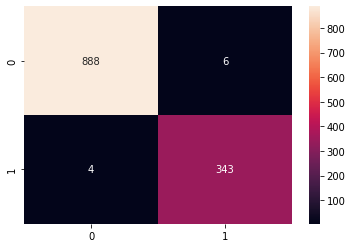

In [136]:
from sklearn import metrics 
import seaborn as sb
import pandas as pd

y_predict = cnn_hog_model.predict(X_test)
# np.argmax(y_predict[0])
y_predic = [np.argmax(prob) for prob in y_predict]

print("Classification report : " , metrics.classification_report(y_test, y_predic) )
cm =  metrics.confusion_matrix(y_test, y_predic)
lbl = ['Yes' , 'No']
dataframe = pd.DataFrame(cm)
sb.heatmap(dataframe, annot=True , fmt='d')

In [ ]:
# PRINTING PERFORMANCE EVALUATION AND CONFUSION MATRIX

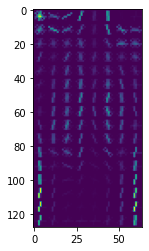

In [103]:
gray_hog_image = X_hog[0]
# gray_hog_image = cv2.cvtColor(image,  cv2.COLOR_BGR2GRAY)
plt.imshow(gray_hog_image)

In [126]:
def getLBPimage(gray_image):
    '''
    == Input ==
    gray_image  : color image of shape (height, width)
    
    == Output ==  
    imgLBP : LBP converted image of the same shape as 
    '''
    
    ### Step 0: Step 0: Convert an image to grayscale
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    imgLBP = np.zeros_like(gray_image)
    neighboor = 3 
    for ih in range(0,image.shape[0] - neighboor):
        for iw in range(0,image.shape[1] - neighboor):
            ### Step 1: 3 by 3 pixel
            img          = gray_image[ih:ih+neighboor,iw:iw+neighboor]
            center       = img[1,1]
            img01        = (img >= center)*1.0
            img01_vector = img01.T.flatten()
            # it is ok to order counterclock manner
            # img01_vector = img01.flatten()
            ### Step 2: **Binary operation**:
            img01_vector = np.delete(img01_vector,4)
            ### Step 3: Decimal: Convert the binary operated values to a digit.
            where_img01_vector = np.where(img01_vector)[0]
            if len(where_img01_vector) >= 1:
                num = np.sum(2**where_img01_vector)
            else:
                num = 0
            imgLBP[ih+1,iw+1] = num
    return(imgLBP)

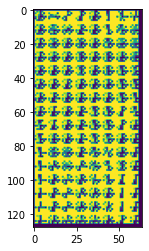

In [127]:
lbp_image = getLBPimage(gray_hog_image)
plt.imshow(lbp_image)

In [137]:
# EXTRATING LBP FEATURES FROM HOG

lbp_features = [] 
for image in X_hog:
    lbp_img = getLBPimage(image)
    lbp_features.append(lbp_img)

print("feature extraction completed...")

feature extraction completed...
